In [1]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

## Exercice 2.

Solve the 2D linear Elasticity with FEniCS:

$$
-\nabla \cdot \sigma = f\hbox{ in }\Omega,
$$
$$
\sigma {\bf n} = {\bf g} \text{ on } \Gamma_{top},
$$
$$
 u =  0 \text{ on }  \Gamma_{right},
$$

where

\begin{equation}
{\sigma}({\bf u})= \lambda({\nabla}\cdot {\bf u}){I} + \mu({\nabla} \boldsymbol{\bf u} + ({\nabla} {\bf u})^T),
\end{equation}

$\lambda$, $\mu$ are the Lamé coefficients describing the mechanical properties of the material, that are related
to the Young’s modulus $E$ and Poisson’s ratio $\nu$ as follows:

$$
 \lambda = \dfrac{E\nu}{(1+\nu)(1-2\nu)}, \quad \mu = \dfrac{E}{2(1+\nu)}.
$$

Use the following data to solve the problem:

* The domain $\Omega$ is shown in the following figure:

![image.png](attachment:image.png)

* Young's modulus and Poisson's ratio:

$$ E = 250.e6, \quad nu = 0.33.$$

* The load:
  1. $$f = 0$$
  2. $${\bf g} = (0.0,-150.0)$$



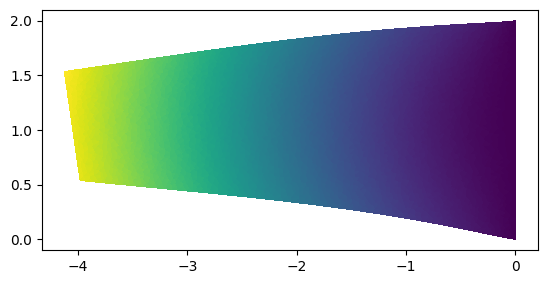

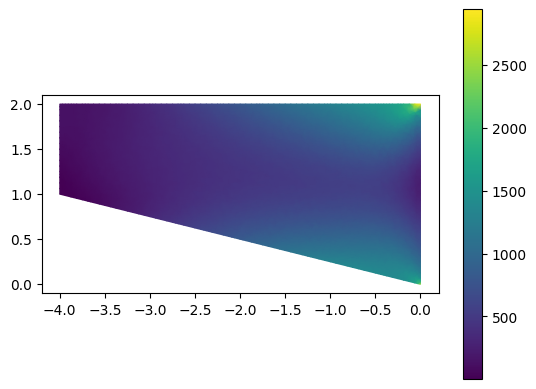

In [4]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt

# Create list of polygonal domain vertices
N = 50
domain_vertices = [Point(-4.0, 2.0),
                   Point(-4.0, 1.0),
                   Point(0.0, 0.0),
                   Point(0.0, 2.0),
                   Point(-4.0, 2.0)]
domain = Polygon(domain_vertices)
mesh = generate_mesh(domain, N)

# --------------------
# Functions and classes
# --------------------

def right(x, on_boundary):
    return on_boundary and near(x[0], 0.0)

# Strain function
def epsilon(u):
    return sym(grad(u))

# Stress function
def sigma(u):
    return lambda_*div(u)*Identity(2) + 2*mu*epsilon(u)

# --------------------
# Parameters
# --------------------

# Young's modulus and Poisson's ratio
E =  250e6
nu = 0.33

# Lame's constants
lambda_ = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)

# --------------------
# Function spaces
# --------------------
V = VectorFunctionSpace(mesh, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)

# --------------------
# Boundary conditions
# --------------------
# Define Dirichlet boundary condition
bc = DirichletBC(V, Constant((0.0, 0.0)), right)

# Definition of Neumann condition domain
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

top = AutoSubDomain(lambda x: near(x[1], 2.0))
top.mark(boundaries, 1)

# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=boundaries)

# Uniform vertical loading due to self-weight
f = Constant((0., 0.))
# Surface load
g = Constant((0.0, -150.0))

# Define variational problem
a = inner(sigma(u), epsilon(v)) * dx
l = dot(f, v) * dx + dot(g, v) * ds(1)

u = Function(V, name='Displacement')
# Compute solution
solve(a == l, u, bc, solver_parameters={"linear_solver": "cg", "preconditioner": "hypre_amg"})

# Plot Deformed Shape
plt.figure()
# Scale factor
factor = 10000
plot(factor * u, mode="displacement")
# Plot stress σxx
plt.figure()
s = sigma(u) - (1./3)*tr(sigma(u))*Identity(2) # Deviatoric stress
von_Mises = sqrt(3./2*inner(s, s))
p = plot(von_Mises, mode='color')
plt.colorbar(p)
plt.show()